In [88]:
# Config

from sentinelhub import SHConfig

config = SHConfig()
config.instance_id = "42886364-18e1-45e8-a4b0-c4a0c6600e89"
config.sh_client_id = "ac6ca0b7-a859-4801-8808-a6542a8ab077"
config.sh_client_secret = "}5[!??UG9W>d{Ud~Ao<7xW0]%DF!8l/SPr^#|WNi"
config.save()

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

# Imports

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from datetime import datetime, timedelta
import os

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

import json
import re
import shapely.wkt

from utils import plot_image


In [91]:
class gt_metadata():

    def __init__(self, filename) -> None:
        
        with open(filename) as jsonfile:
            self.d = json.load(jsonfile)

        self.coordinates = shapely.wkt.loads(self.d["raw_location"])
        self.bbox = BBox(self.coordinates.bounds, crs=CRS.WGS84)
        self.espg = self.d["epsg"]
        self.category = self.d["bounding_boxes"][0]["category"]
        self.timestamp = self.d["timestamp"]
        self.datetime = datetime.strptime(self.timestamp, "%Y-%m-%dT%H:%M:%SZ")


    def plot_sentinel1(self, resolution=5, days_margin=1000, save_data=False):

        evalscript_RGB1 = """
        //VERSION=3

        return [VH, VH-VV, VV]
        """
        size = bbox_to_dimensions(self.bbox, resolution=resolution)
        time_interval = ((self.datetime-timedelta(days=days_margin//2)).strftime("%Y-%m-%d"), 
                         (self.datetime+timedelta(days=days_margin//2)).strftime("%Y-%m-%d"))
        time_interval= ("2014-04-15", datetime.now().strftime("%Y-%m-%d"))
        request_sar = SentinelHubRequest(
            data_folder="test_gt",
            evalscript=evalscript_RGB1,
            input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL1_IW,
                time_interval=time_interval,
            )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=self.bbox,
            size=size,
            config=config,
        )

        sar_imgs = request_sar.get_data(save_data=save_data)
        image = sar_imgs[0]
        # plot function
        # factor 1/255 to scale between 0-1
        # factor 3.5 to increase brightness
        print(f"Returned data is of type = {type(sar_imgs)} and length {len(sar_imgs)}.")
        print(f"Single element in the list is of type {type(sar_imgs[-1])} and has shape {sar_imgs[-1].shape}")
        plot_image(image, factor=3.5 / 255, clip_range=(0, 1))


    def plot_sentinel2(self, resolution=5, days_margin=1000, save_data=False):
        evalscript_true_color = """
        //VERSION=3

        function setup() {
            return {
                input: [{
                    bands: ["B02", "B03", "B04"]
                }],
                output: {
                    bands: 3
                }
            };
        }

        function evaluatePixel(sample) {
            return [sample.B04, sample.B03, sample.B02];
        }
        """
        size = bbox_to_dimensions(self.bbox, resolution=resolution)
        time_interval = ((self.datetime-timedelta(days=days_margin//2)).strftime("%Y-%m-%d"), 
                         (self.datetime+timedelta(days=days_margin//2)).strftime("%Y-%m-%d"))
        
        request_true_color = SentinelHubRequest(
            data_folder="test_gt",
            evalscript=evalscript_true_color,
            input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
            )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=self.bbox,
            size=size,
            config=config,
        )

        true_color_imgs = request_true_color.get_data(save_data=save_data)
        image = true_color_imgs[0]
        print(f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}.")
        print(f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}")
        # plot function
        # factor 1/255 to scale between 0-1
        # factor 3.5 to increase brightness
        plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

        

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (765, 757, 3)


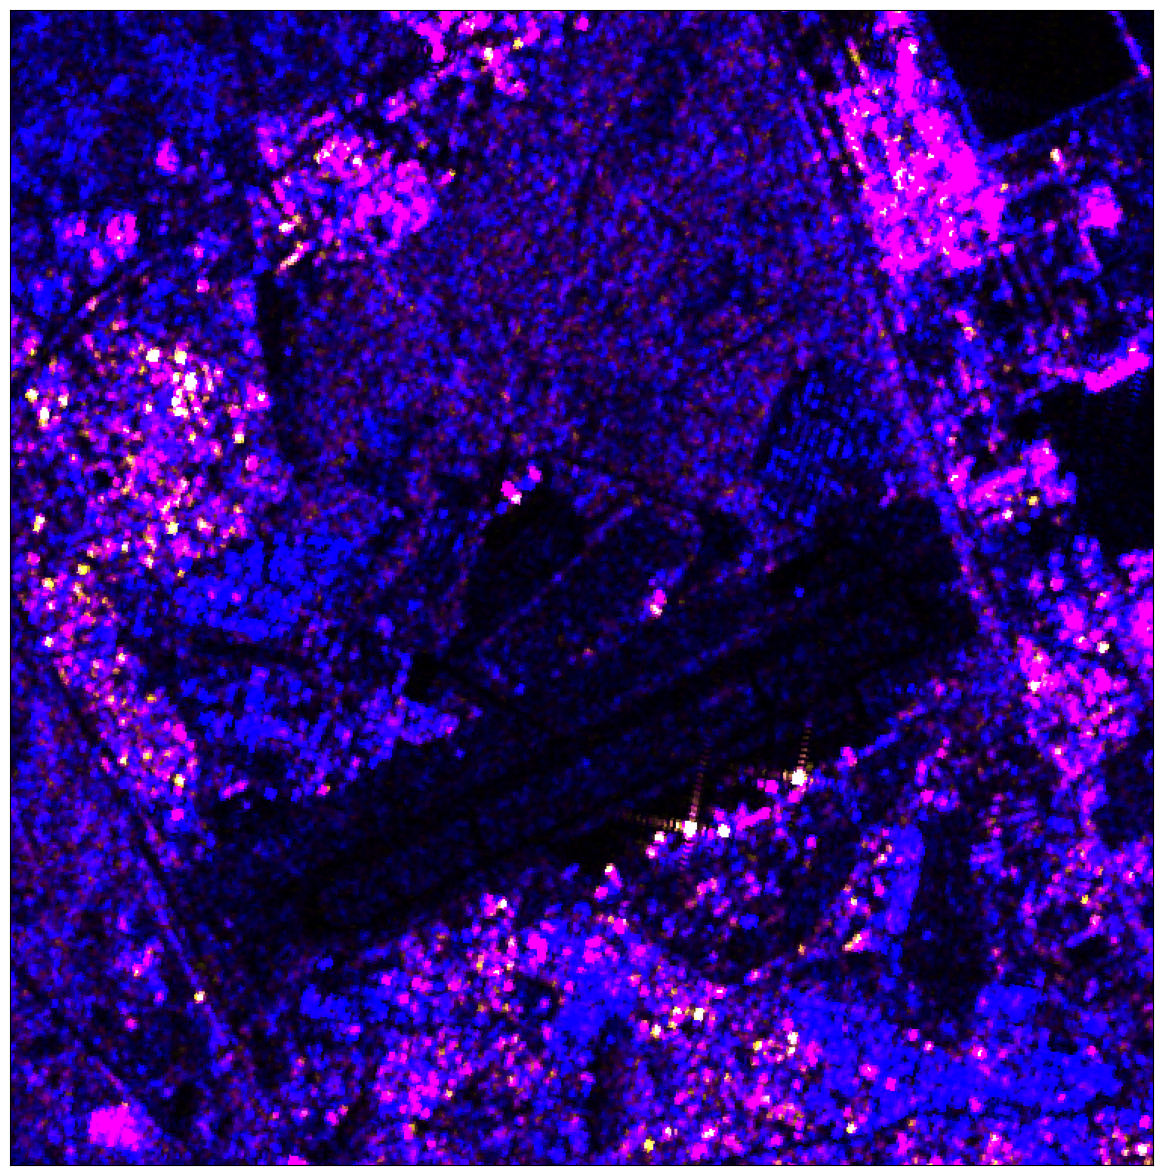

In [92]:
filename = "groundtruth/seq_gt/airport/airport_2/airport_2_9_rgb.json"
gt_data = gt_metadata(filename=filename)
gt_data.plot_sentinel1(resolution=5, save_data=True)


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (765, 757, 3)
Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (382, 378, 3)
Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (255, 252, 3)
Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (191, 189, 3)
Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (153, 151, 3)


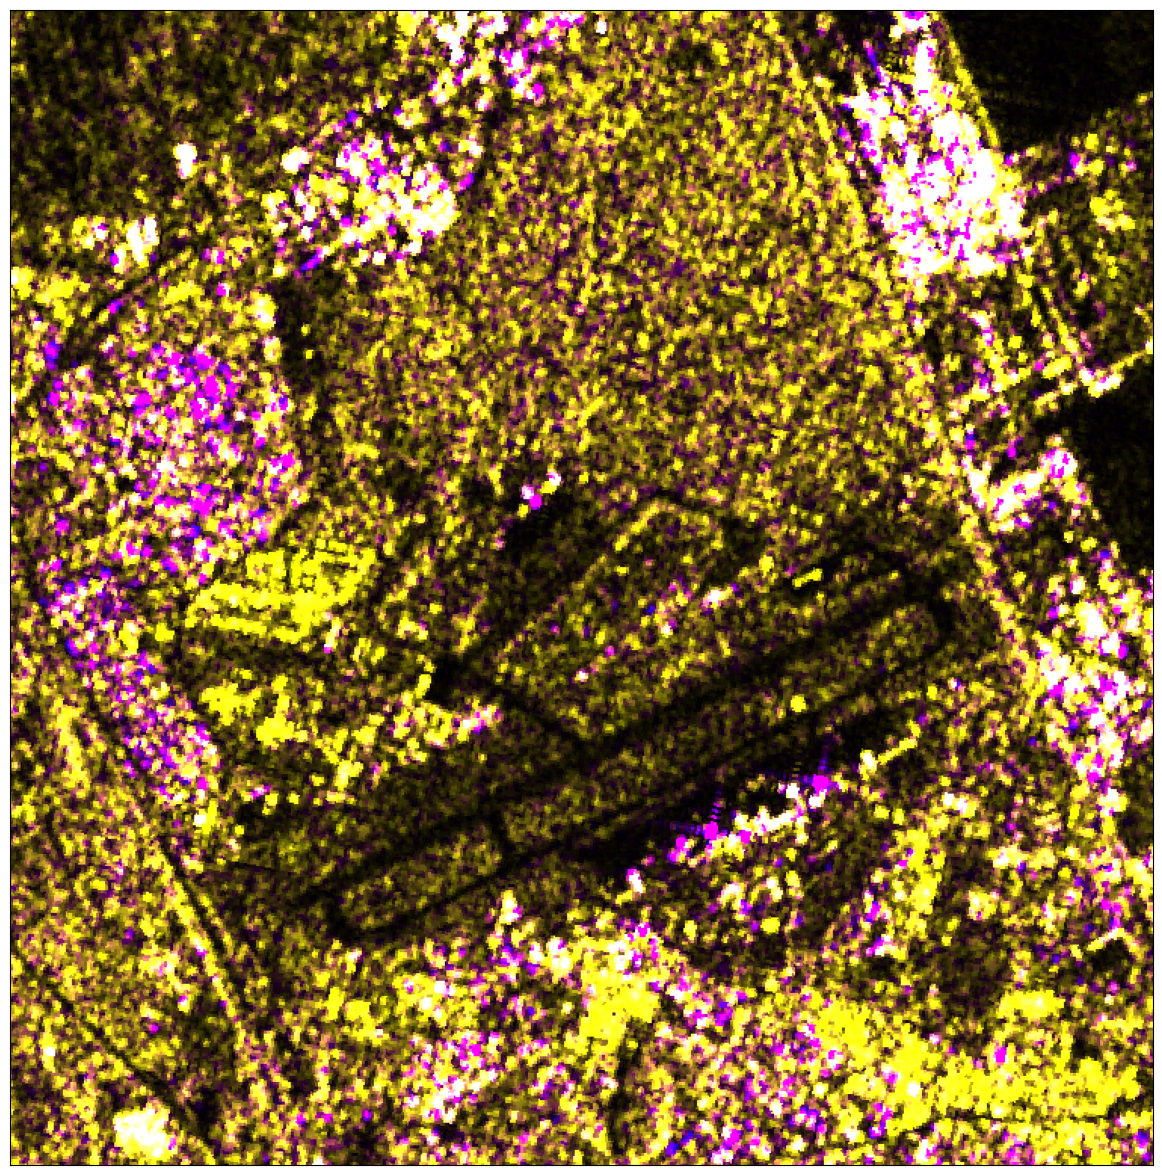

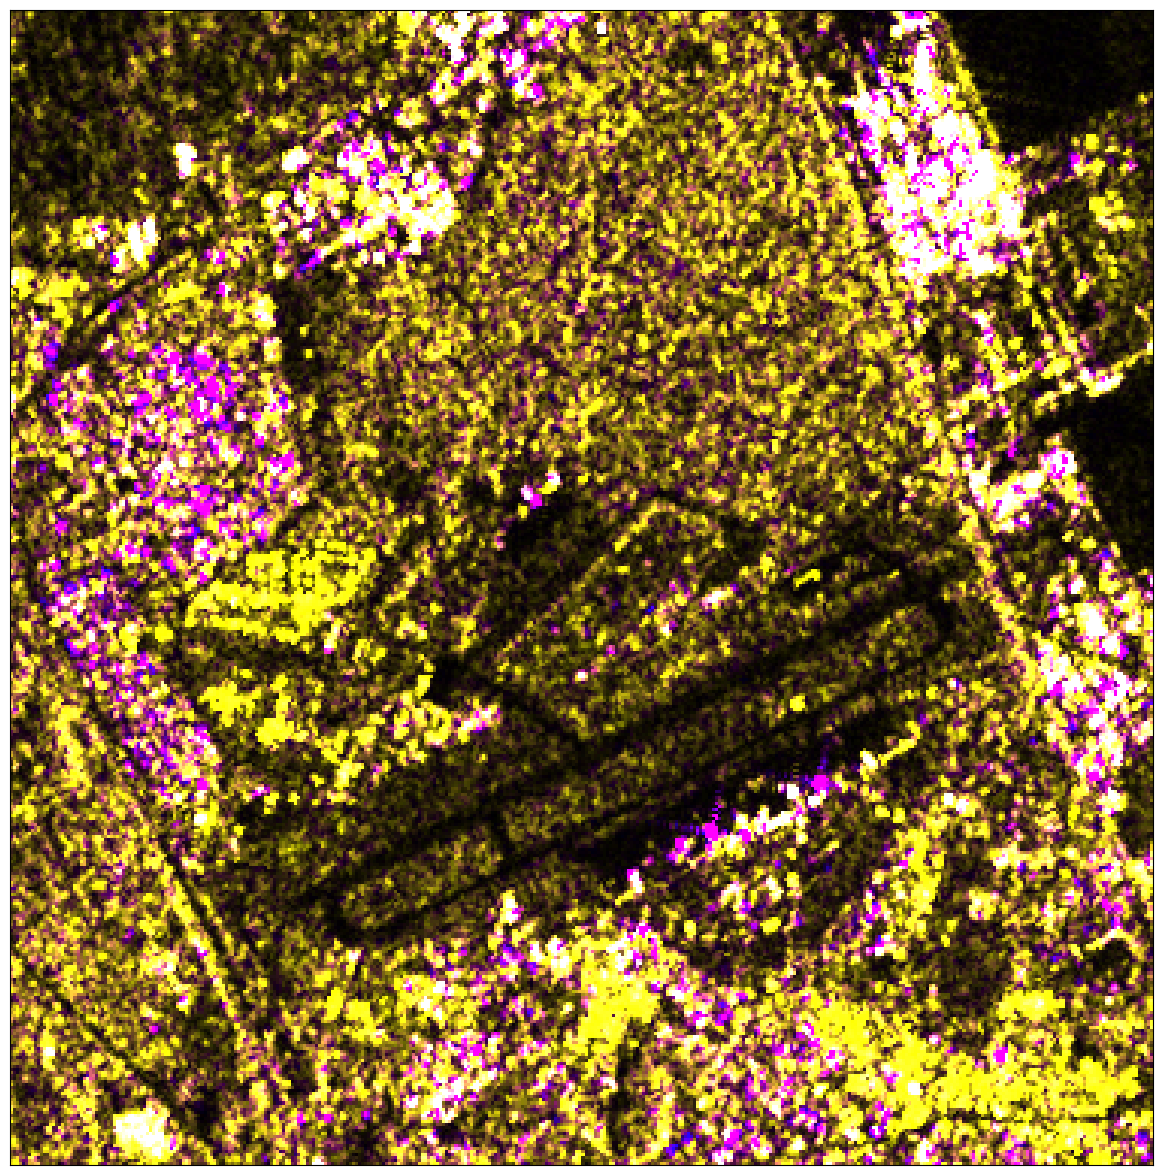

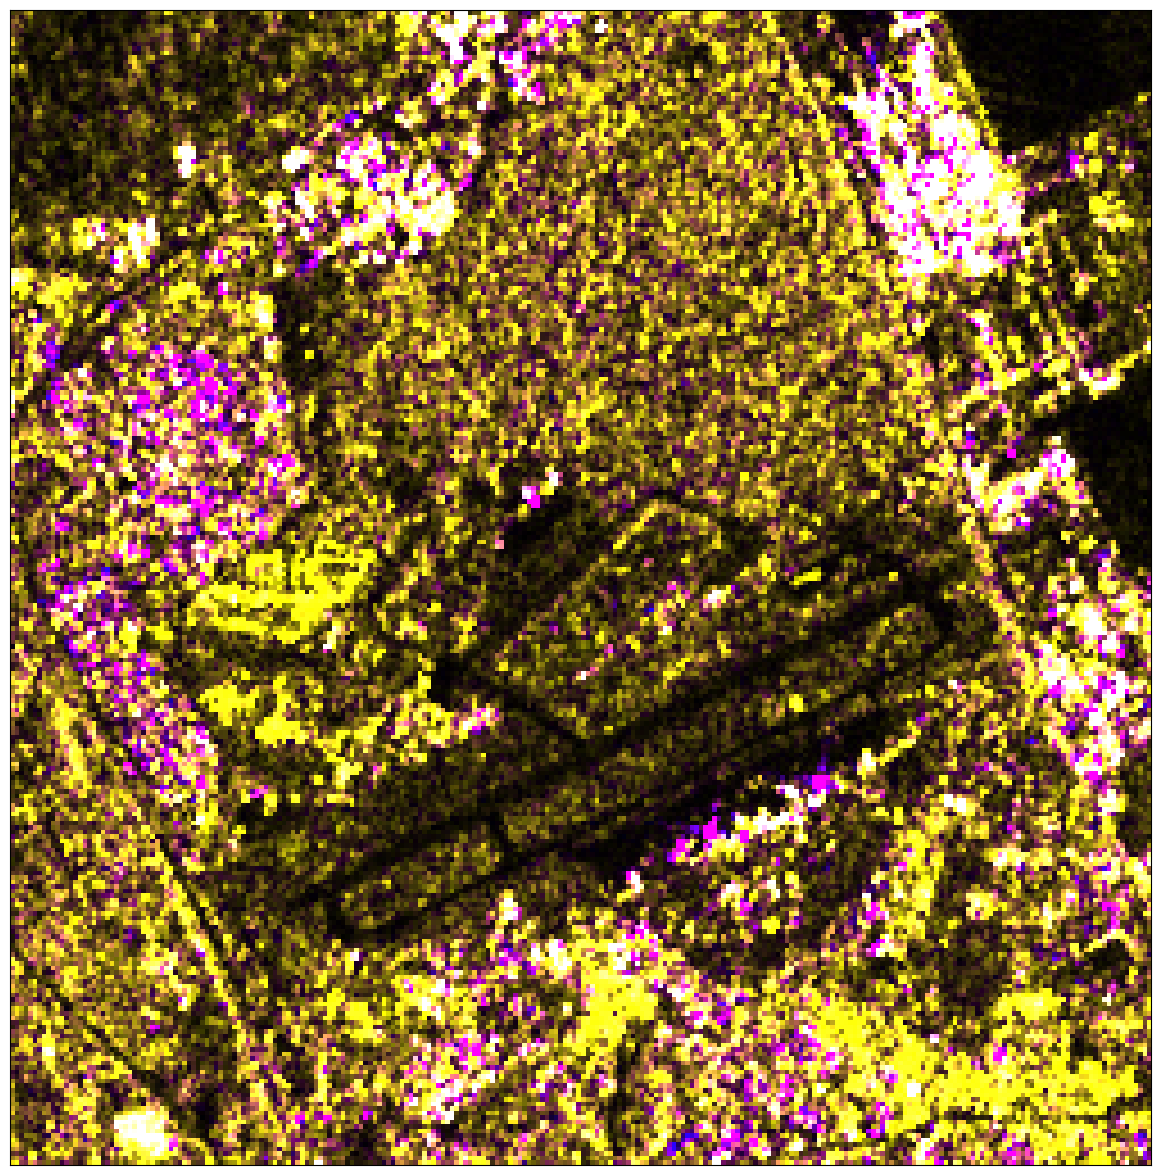

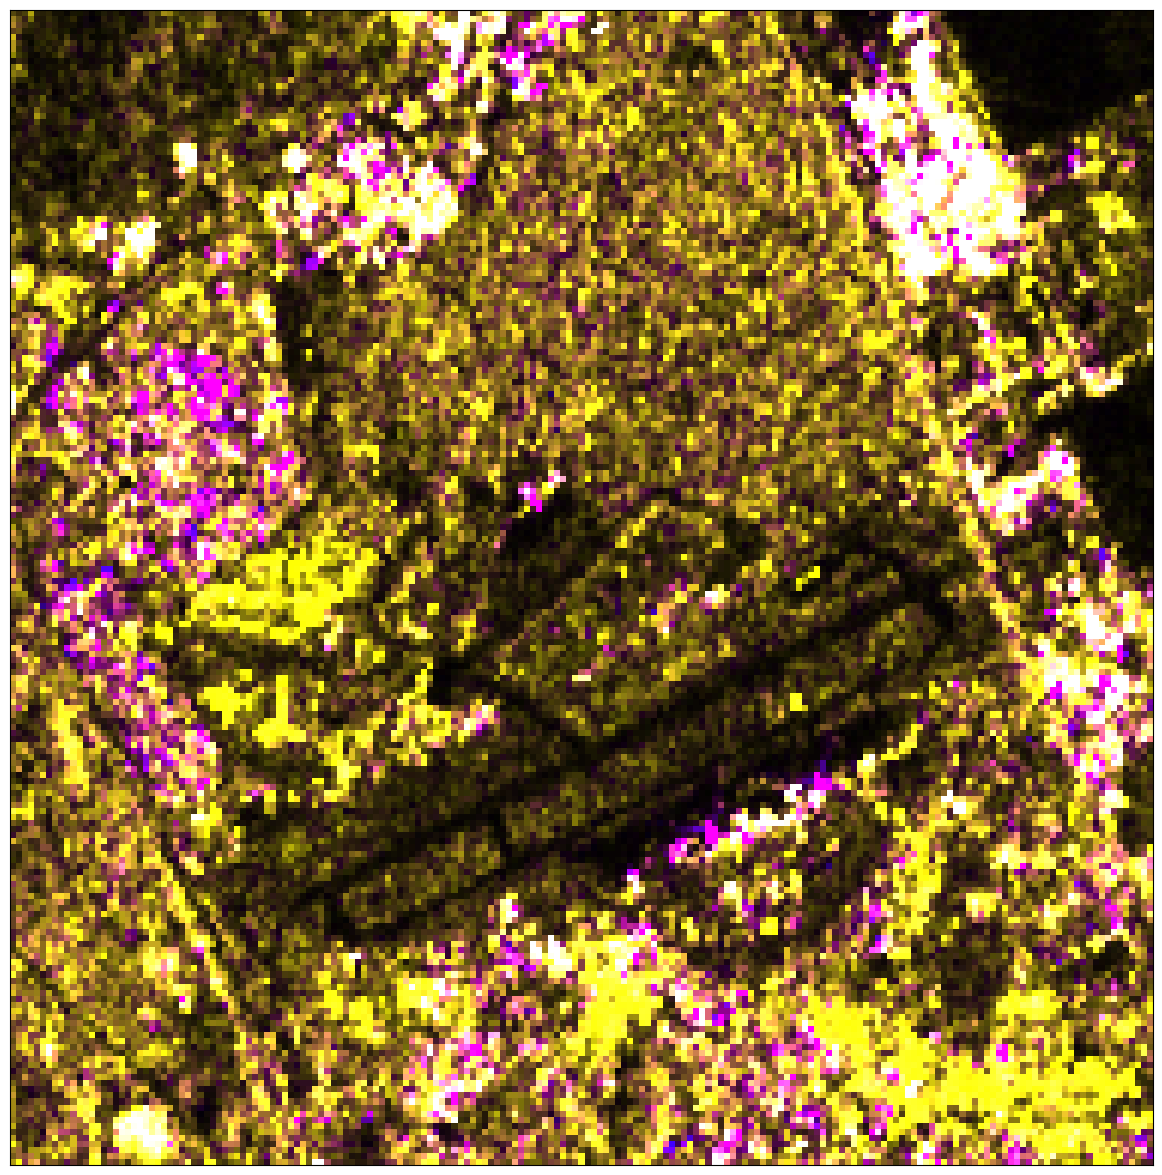

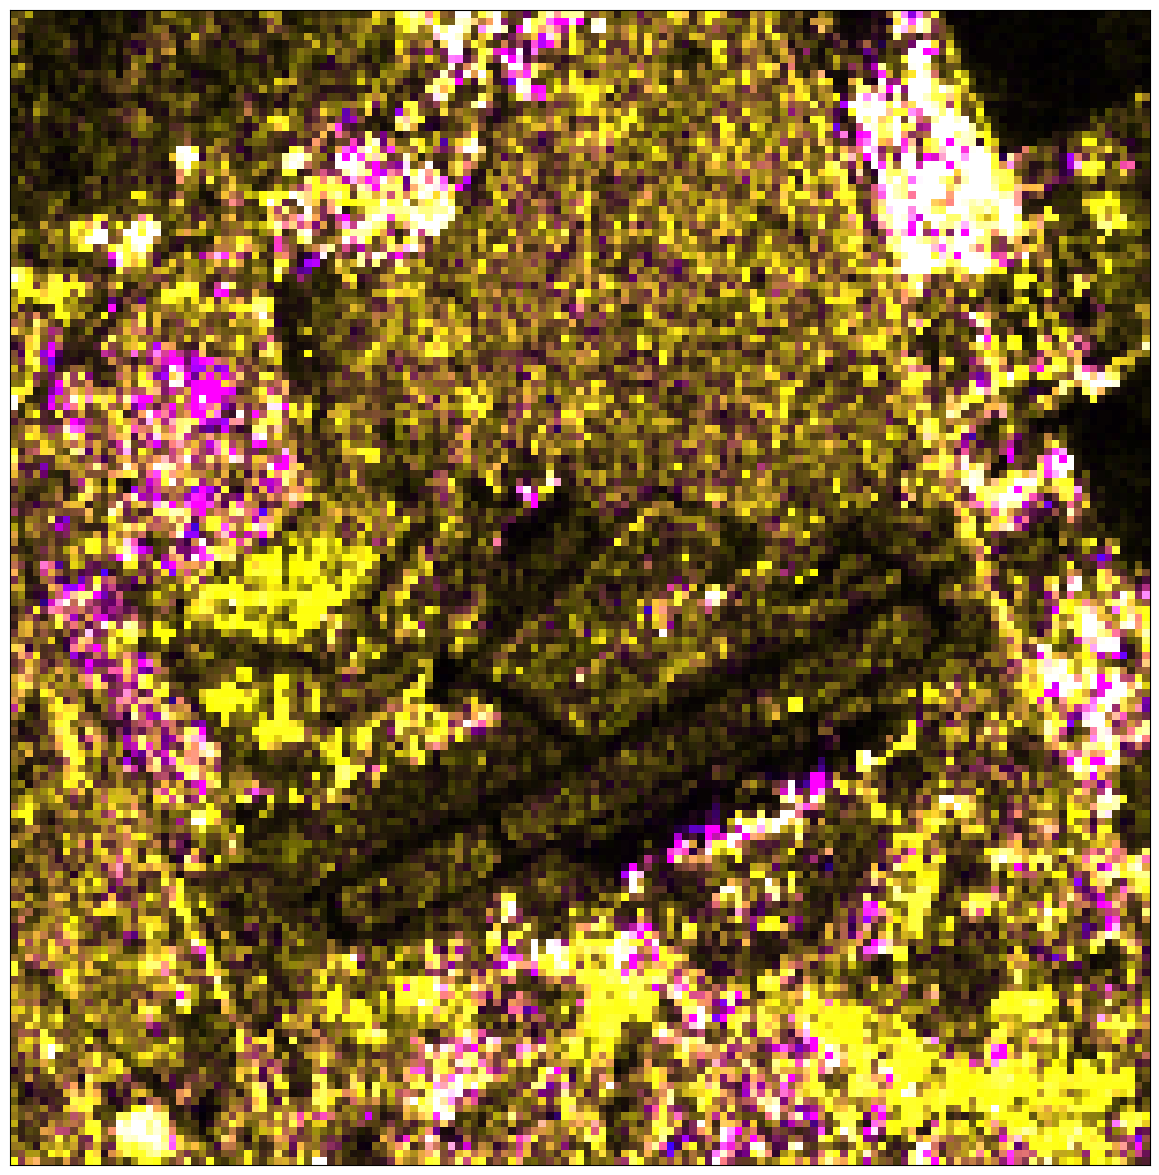

In [73]:
for i in range(5,30,5):
    gt_data.plot_sentinel1(resolution=i)